# Problem Statement 2: Fake News
Fake contents are everywhere from social media platforms, news platforms and there is a big list. Considering the advancement in NLP research institutes are putting a lot of sweat, blood, and tears to detect the fake content generated across the platforms.

Fake news, defined by the New York Times as “a made-up story with an intention to deceive”, often for a secondary gain, is arguably one of the most serious challenges facing the news industry today. In a December Pew Research poll, 64% of US adults said that “made-up news” has caused a “great deal of confusion” about the facts of current events.

## Content
Your goal as a data scientist is to create an NLP model, to combat fake content problems. We believe that these AI technologies hold promise for significantly automating parts of the procedure human fact-checkers use today to determine if a story is real or a hoax.
- Text - Raw content from social media/ new platforms
- Text_Tag - Different types of content tags
- Labels - Represents various classes of Labels
    - Half-True - 2
    - False - 1
    - Mostly-True - 3
    - True - 5
    - Barely-True - 0
    - Not-Known - 4

References
https://www.machinehack.com/hackathons/fake_news_content_detection_weekend_hackathon_20/overview


In [1]:
#import libraries
import sys
import scipy
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import sklearn
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import spacy
import re
import string

#suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Cause plots to be displayed in the notebook:
%matplotlib inline
#print('Available plot styles: ' + str(plt.style.available))
plt.style.use('seaborn-whitegrid')
print('MINI PROJECT 3 - PROBLEM STATEMENT 2: FAKE NEWS')
print('='*88)
print('Python: \t', sys.version)
print('Scipy:  \t', scipy.__version__)
print('SKLearn:  \t', sklearn.__version__)
print('Numpy:  \t', np.__version__)
print('Pandas: \t', pd.__version__)
print('MatPlotLib: \t', matplotlib.__version__)
print('Author: \t Lawrance Koh (@LK)')
print('Team:   \t Jav & Lawrance (@LK)')
print('='*88, "\n")


MINI PROJECT 3 - PROBLEM STATEMENT 2: FAKE NEWS
Python: 	 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Scipy:  	 1.5.2
SKLearn:  	 0.23.2
Numpy:  	 1.19.2
Pandas: 	 1.1.3
MatPlotLib: 	 3.3.2
Author: 	 Lawrance Koh (@LK)
Team:   	 Jav & Lawrance (@LK)



In [2]:
#read data
train_csv = 'Participants_Data_WH20/Participants_Data_WH20/Train.csv'
test_csv = 'Participants_Data_WH20/Participants_Data_WH20/Test.csv'

df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Labels    10240 non-null  int64 
 1   Text      10240 non-null  object
 2   Text_Tag  10238 non-null  object
dtypes: int64(1), object(2)
memory usage: 240.1+ KB


In [4]:
#there were 2 null values in Text_Tag; proceed to fill with empty strings
df['Text_Tag'].fillna('', inplace=True)

df['Labels'].value_counts()

2    2114
1    1995
3    1962
5    1676
0    1654
4     839
Name: Labels, dtype: int64

#### Comment: 839 data points in training data were labelled as 'unknown'; add these to test set and drop them from training set.

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      1267 non-null   object
 1   Text_Tag  1267 non-null   object
dtypes: object(2)
memory usage: 19.9+ KB


#### Comment: 1267 data points exists in original test set.

In [6]:
#drop 'Not Known' data from training set; add to test set
temp_df = df[df['Labels']==4].drop(columns=['Labels'])
test_df = pd.concat([test_df, temp_df])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      2106 non-null   object
 1   Text_Tag  2106 non-null   object
dtypes: object(2)
memory usage: 49.4+ KB


#### Comment: 2106 data points in total after adding from training set with 'unknown' labels.

In [7]:
df.drop(labels=df[df['Labels']==4].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9401 entries, 0 to 10238
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Labels    9401 non-null   int64 
 1   Text      9401 non-null   object
 2   Text_Tag  9401 non-null   object
dtypes: int64(1), object(2)
memory usage: 293.8+ KB


In [8]:
df['Labels'].value_counts()

2    2114
1    1995
3    1962
5    1676
0    1654
Name: Labels, dtype: int64

#### Comment: Re-classify 'false'(1), 'barely true'(0) and 'half true'(2) as FAKE NEWS(1); while 'true'(5) and 'mostly true'(3) as REAL NEWS(0)

In [9]:
df['Fake'] = df['Labels'].apply(lambda x: 1 if x==0 or x==1 or x==2 else 0)
df['Fake'].value_counts()

1    5763
0    3638
Name: Fake, dtype: int64

In [10]:
df.sample(10)

,Labels,Text,Text_Tag,Fake
8586,2,Says Hillary Clinton has called for a radical ...,"foreign-policy,homeland-security,human-rights,...",1
9104,2,Even after Syrian troops began to shoot protes...,foreign-policy,1
9371,2,"For every dollar we put in unemployment, it pa...","economy,stimulus",1
7229,2,Our high school graduation rate is the highest...,"children,corrections-and-updates,education",1
1483,0,"Obama ""says he'll raise taxes on electricity.""",taxes,1
2665,0,The average minimum wage worker is 35 years old.,"economy,jobs",1
4978,1,Medicare will be bankrupt in nine years.,medicare,1
8651,2,"Over the last several years, 40 percent (of) t...","economy,immigration,jobs",1
3318,5,"Amiddle-class family donates $1 to charity, th...",taxes,0
90,1,"Phoenix, Arizona, is the No. 2 kidnapping capi...",immigration,1


#### Comment: Inspect Text_Tag

In [11]:
#check to see if Text_Tag should be used as feature to predict Fake News
df['Text_Tag'].value_counts()

health-care                                              344
taxes                                                    287
immigration                                              228
education                                                228
elections                                                222
                                                        ... 
congress,history,military,terrorism                        1
elections,immigration,message-machine-2012                 1
retirement,social-security                                 1
job-accomplishments,jobs,message-machine-2012,workers      1
corrections-and-updates,terrorism                          1
Name: Text_Tag, Length: 3582, dtype: int64

#### Comment: Feature Engineering [not used]


In [12]:
'''
%%time

cv = CountVectorizer(analyzer='char')
cv_fit = cv.fit_transform(df['Text'])
df['char_count'] = cv_fit.toarray().sum(axis=1)

cv = CountVectorizer(analyzer='word')
cv_fit = cv.fit_transform(df['Text'])
df['word_count'] = cv_fit.toarray().sum(axis=1)

df['word_density'] = df['char_count'] / df['word_count']
df['punctuation_count'] = df["Text"].str.count(r'[^\w\s]')
df['title_word_count'] = df['Text'].apply(lambda x: len([w for w in x.split() if w.istitle()]))
df['uppercase_word_count'] = df["Text"].str.count(r'[A-Z]')

## load spaCy
nlp = spacy.load('en_core_web_sm')

# Initialise some columns for feature's counts
df['adj_count'] = 0
df['adv_count'] = 0
df['noun_count'] = 0
df['num_count'] = 0
df['pron_count'] = 0
df['propn_count'] = 0
df['verb_count'] = 0

for j in range(len(df)):
    tokens = nlp(df['Text'].iloc[j])
    t_list = []
    for i, t in enumerate(tokens):
        t_list.append(t.pos_)
    c = Counter(t_list)
    df['adj_count'].iloc[j] = c['ADJ']
    df['adv_count'].iloc[j] = c['ADV']
    df['noun_count'].iloc[j] = c['NOUN']
    df['num_count'].iloc[j] = c['NUM']
    df['pron_count'].iloc[j] = c['PRON']
    df['propn_count'].iloc[j] = c['PROPN']
    df['verb_count'].iloc[j] = c['VERB']
'''

'\n%%time\n\ncv = CountVectorizer(analyzer=\'char\')\ncv_fit = cv.fit_transform(df[\'Text\'])\ndf[\'char_count\'] = cv_fit.toarray().sum(axis=1)\n\ncv = CountVectorizer(analyzer=\'word\')\ncv_fit = cv.fit_transform(df[\'Text\'])\ndf[\'word_count\'] = cv_fit.toarray().sum(axis=1)\n\ndf[\'word_density\'] = df[\'char_count\'] / df[\'word_count\']\ndf[\'punctuation_count\'] = df["Text"].str.count(r\'[^\\w\\s]\')\ndf[\'title_word_count\'] = df[\'Text\'].apply(lambda x: len([w for w in x.split() if w.istitle()]))\ndf[\'uppercase_word_count\'] = df["Text"].str.count(r\'[A-Z]\')\n\n## load spaCy\nnlp = spacy.load(\'en_core_web_sm\')\n\n# Initialise some columns for feature\'s counts\ndf[\'adj_count\'] = 0\ndf[\'adv_count\'] = 0\ndf[\'noun_count\'] = 0\ndf[\'num_count\'] = 0\ndf[\'pron_count\'] = 0\ndf[\'propn_count\'] = 0\ndf[\'verb_count\'] = 0\n\nfor j in range(len(df)):\n    tokens = nlp(df[\'Text\'].iloc[j])\n    t_list = []\n    for i, t in enumerate(tokens):\n        t_list.append(t.pos_

#### Comment: Parse with spacy

In [13]:
df.describe()

,Labels,Fake
count,9401.000000,9401.000000
mean,2.179449,0.613020
std,1.642335,0.487085
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,1.000000
max,5.000000,1.000000


#### Comment: Start Training and Compare accuracies between models

In [14]:
## helper functions

def train_model(classifier, feature_vector_train, label, feature_vector_valid, feature_vector_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    #return accuracy_score(predictions, y_test)
    return show_summary_report(feature_vector_test, predictions)

def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

def plot_distribution(datafile):
    return sns.countplot(x='Fake', data=datafile, palette='hls')

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

nlp = spacy.load('en_core_web_sm')

def parse_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)
    
    #clean up
    text = re.sub(r'[,-]', ' ', text)
    
    return text

#initialise dataframe to view results
df_results = pd.DataFrame(columns=[['Accuracy', 'Precision', 'Recall', 'ROC_AUC']])


<AxesSubplot:xlabel='Fake', ylabel='count'>

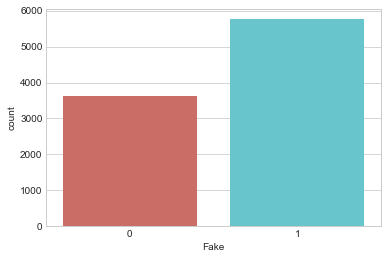

In [15]:
plot_distribution(df)

In [16]:
%%time

'''
features = ['Text', 'char_count', 'word_count',
       'word_density', 'punctuation_count', 'title_word_count',
       'uppercase_word_count', 'adj_count', 'adv_count', 'noun_count',
       'num_count', 'pron_count', 'propn_count', 'verb_count']
'''
#df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].apply(parse_text)
df['Text']

Wall time: 44.9 s


0        say annies list political group support trimes...
1        decline coal start start natural gas take star...
2        hillary clinton agree john mccain vote george ...
3        health care reform legislation likely mandate ...
4                       economic turnaround start end term
                               ...                        
10234    ruling supreme court lobbyist legislator vote ...
10235    large number shark attack Florida case voter f...
10236             Democrats party Atlanta metro area black
10237    say alternative social security operate galves...
10238            lift U.S. Cuban embargo allow travel Cuba
Name: Text, Length: 9401, dtype: object

In [17]:
%%time

X = df['Text']
y = df['Fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

tv = TfidfVectorizer()
Xv_train = tv.fit_transform(X_train)
Xv_test = tv.transform(X_test)

Xv_train.shape, y_train.shape, Xv_test.shape, y_test.shape

Wall time: 98.8 ms


((7050, 7692), (7050,), (2351, 7692), (2351,))

#### Comment: Logistics Regression

Accuracy : 0.6261 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6564 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8412 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5552                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


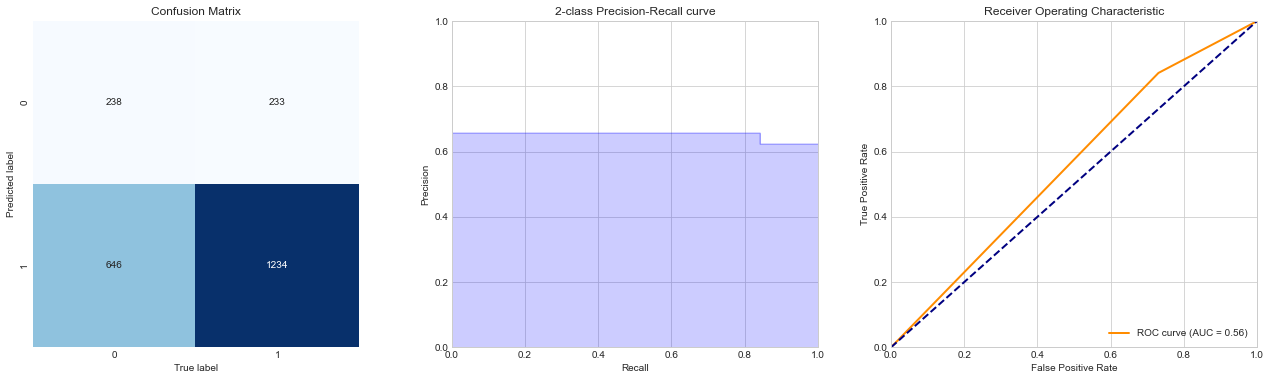

Wall time: 360 ms


In [18]:
%%time

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
df_results.loc['LogisticRegression'] = train_model(clf, Xv_train, y_train, Xv_test, y_test)

#### Comment: Naive Bayes

Accuracy : 0.6291 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6386 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9346 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5284                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


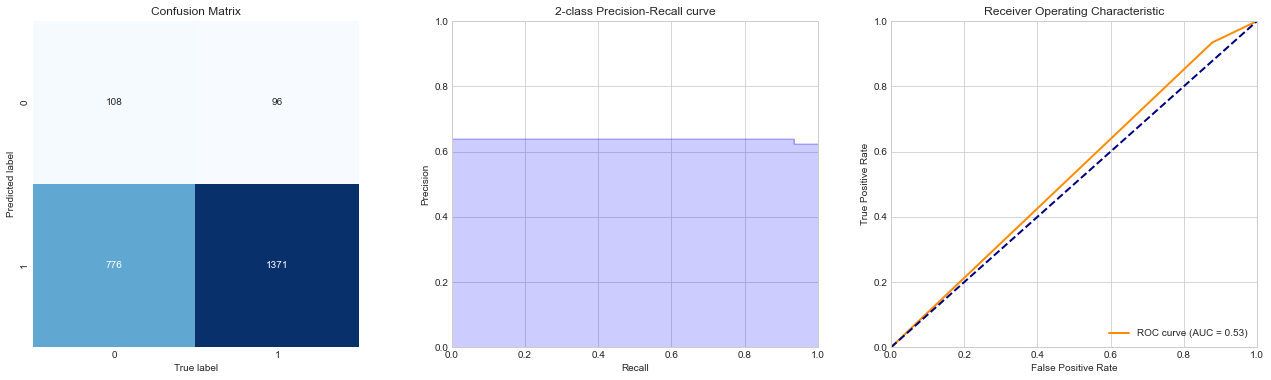

Wall time: 274 ms


In [19]:
%%time

from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
df_results.loc['NaiveBayes'] = train_model(nb_clf, Xv_train, y_train, Xv_test, y_test)


#### Comment: Random Forest

Accuracy : 0.6299 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6580 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8473 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5583                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


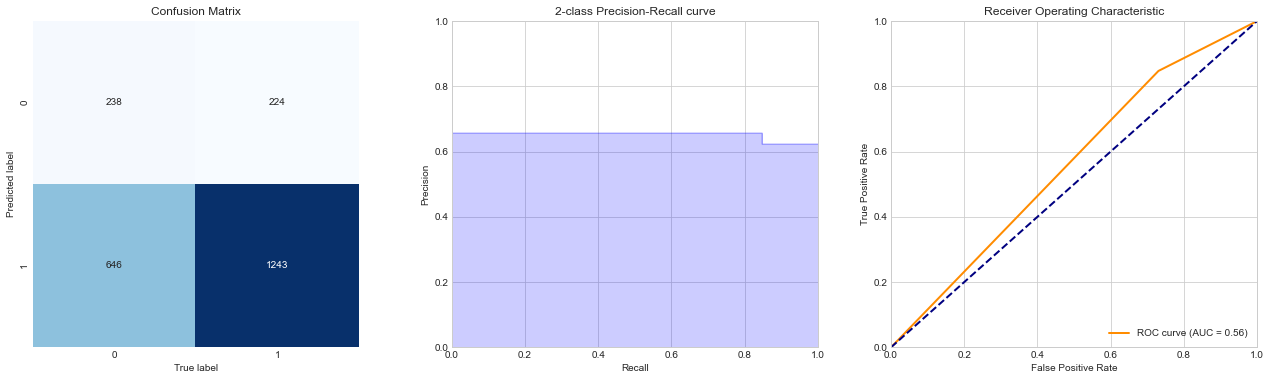

Wall time: 4.35 s


In [20]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

df_results.loc['RandomForest'] = train_model(rf_clf, Xv_train, y_train, Xv_test, y_test)


#### Comment: Gradient Boosting

Accuracy : 0.6227 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6350 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9298 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5215                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


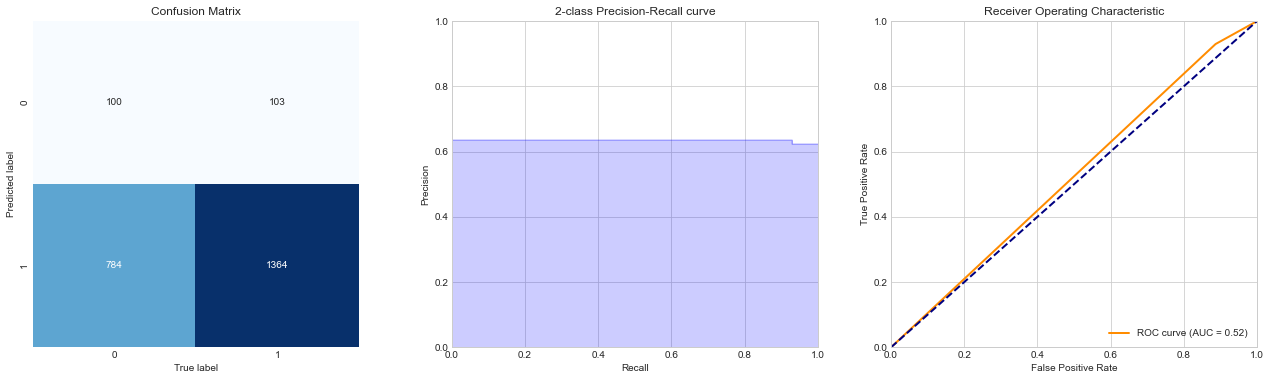

Wall time: 1.69 s


In [21]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

df_results.loc['GradientBoosting'] = train_model(gb_clf, Xv_train, y_train, Xv_test, y_test)


#### Comment: View and compare results of different models

In [22]:
df_results

,Accuracy,Precision,Recall,ROC_AUC
LogisticRegression,0.626117,0.656383,0.841172,0.555202
NaiveBayes,0.629094,0.638565,0.934560,0.528366
RandomForest,0.629945,0.658020,0.847307,0.558269
GradientBoosting,0.622714,0.635009,0.929789,0.521455


#### Comment: Stacking

Accuracy : 0.6321 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6484 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8964 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5449                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


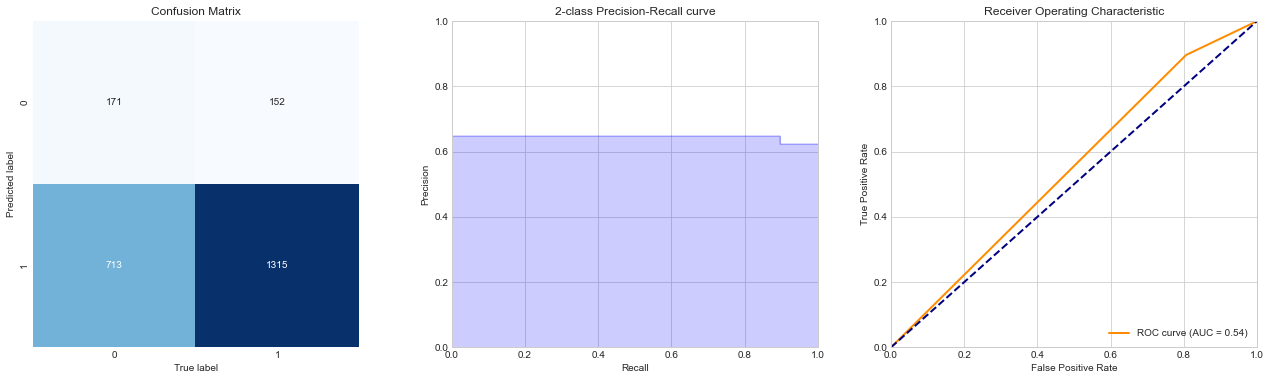

Wall time: 1min 2s


In [23]:
%%time

from sklearn.ensemble import StackingClassifier

estimators = [
    ('nb', nb_clf),
    ('rf', rf_clf),
    ('gb', gb_clf)]

stack_model = StackingClassifier(estimators=estimators, final_estimator=clf)

df_results.loc['StackModel'] = train_model(stack_model, Xv_train, y_train, Xv_test, y_test)


In [24]:
df_results

,Accuracy,Precision,Recall,ROC_AUC
LogisticRegression,0.626117,0.656383,0.841172,0.555202
NaiveBayes,0.629094,0.638565,0.934560,0.528366
RandomForest,0.629945,0.658020,0.847307,0.558269
GradientBoosting,0.622714,0.635009,0.929789,0.521455
StackModel,0.632071,0.648422,0.896387,0.544913


#### Comment: Finally apply predictions (using stack model) on Test Set

<AxesSubplot:xlabel='Fake', ylabel='count'>

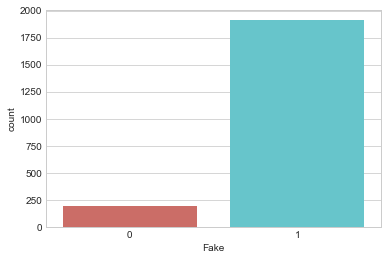

In [27]:
pred = tv.transform(test_df['Text'].apply(parse_text))
test_df['Fake'] = stack_model.predict(pred)
plot_distribution(test_df)

In [28]:
test_df

,Text,Text_Tag,Fake
0,Building a wall on the U.S.-Mexico border will...,immigration,1
1,Wisconsin is on pace to double the number of l...,jobs,1
2,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",1
3,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",1
4,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",1
...,...,...,...
10203,"Says Bernie Sanders wins California landslide,...",elections,1
10206,Gov. Scott Walker (is) more than halfway to (h...,jobs,1
10227,"Recently though, the media has reported on tho...",elections,1
10233,Mayor Fung wants to punish our childrens educa...,"children,city-budget,deficit,education,state-b...",1
